# Avis Restau : améliorer le produit IA de votre start-up

## Sommaire

* [I. Préambule](#I)
    * [1. Contexte](#I1)
    * [2. Outils utilisés](#I2)
* [II. Pré-traitement et modélisation des données textuelles](#II)
    * [1. Chargement des données textuelles](#II1)
    * [2. Pré-traitement des commentaires](#II2)
    * [3. Visualisation des données textuelles](#II3)
    * [4. Modélisation des données textuelles](#II4)
        * [a. Latent Dirichlet Allocation (LDA)](#II4a)
        * [b. Latent Semantic Analysis (LSA)](#II4b)
        * [c. Negative Matrix Factorisation (NMF)](#II4c)
* [III. Pré-traitement et modélisation des données visuelles](#III)
    * [1. Chargement des données visuelles](#III1)
    * [2. Pré-traitement des images via SIFT](#III2)
    * [3. Réductions de dimension](#III3)
        * [a. Réduction de dimension PCA](#III3a)
        * [b. Réduction de dimension T-SNE](#III3b)
    * [4. Analyse visuelle : affichage T-SNE selon les catégories d'images](#III4)
    * [5. Analyse mesures : similarité entre catégories et clusters](#III5)
        * [a. Création de clusters à partir du T-SNE](#III5a)
        * [b. Affichage des images selon clusters et calcul ARI de similarité catégories images/clusters](#III5b)
        

## I. Préambule<a class="anchor" id="I"></a>

### 1. Contexte<a class="anchor" id="I1"></a>

Je suis Ingénieur IA au sein de la startup “Avis Restau”, qui met en relation des clients et des restaurants. Mon entreprise souhaite améliorer sa plateforme avec une nouvelle fonctionnalité de collaboration. Les utilisateurs pourront par exemple poster des avis et des photos sur leur restaurant préféré. Ce sera aussi l’occasion, pour l’entreprise, de mieux comprendre les avis postés par les utilisateurs.

### 2. Outils utilisés<a class="anchor" id="I2"></a>

Nous allons utiliser le langage Python, et présenter ici le code, les résultats et l'analyse
sous forme de <a href='https://jupyter.org/'>Notebook Jupyter</a>.

Nous allons aussi utiliser les bibliothèques usuelles d'exploration et d'analyse de données,
afin d'améliorer la simplicité et la performance de notre code :
* <a href='https://numpy.org/'>NumPy</a> et <a href='https://pandas.pydata.org/'>Pandas</a> : effectuer des calculs scientifiques (statistiques, algèbre, ...) et manipuler des séries et tableaux de données volumineuses et complexes
* <a href='https://matplotlib.org/'>Matplotlib</a>, <a href='https://seaborn.pydata.org/'>Seaborn</a> et <a href='https://plotly.com/'>Plotly</a> : générer des graphiques lisibles, intéractifs et pertinents
* <a href='https://scikit-learn.org/stable/'>Scikit-learn</a> : effectuer le preprocessing des données

In [1]:
# Import libraries
from os import listdir

# Math libraries to process the data 
import numpy as np 
import pandas as pd

# Libraries for modelling 
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF, PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn import manifold
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from wordcloud import WordCloud, STOPWORDS
import time, cv2
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Libraries for preprocessing data analysis
import nltk
import string
import re
import cv2
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn import cluster, metrics
from sklearn.preprocessing import LabelEncoder 

# Graph libraries to produce graphs 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import seaborn as sns 
from matplotlib.image import imread

# Libraries to collect data
from config import api_key
import requests
import json

pd.options.mode.chained_assignment = None

## II. Pré-traitement et modélisation des données textuelles<a class="anchor" id="II"></a>

### 1. Chargement des données textuelles<a class="anchor" id="II1"></a>

Nous allons récupérer le jeu de données de la base de données Yelp. Cette dernière étant conséquente, nous allons devoir optimiser son occupation d'espace mémoire.

In [92]:
# Get businesses data
business_json_path = 'data/yelp_academic_dataset_business.json'
dataframe_business = pd.read_json(business_json_path, lines=True)

# Only keep the businesses that are still open in the dataset
dataframe_business = dataframe_business[dataframe_business['is_open'] == 1]

# Drop any irrelevant columns
drop_columns = ['hours','is_open','review_count']
dataframe_business = dataframe_business.drop(drop_columns, axis=1)

# Find the relevant reviews that we want later on by querying for the relevant businesses first using categories
dataframe_business = dataframe_business[dataframe_business['categories'].str.contains('Restaurants', case=False, na=False)]

# Get reviews data
size = 1000000
review_json_path = 'data/yelp_academic_dataset_review.json'
dataframe_review = pd.read_json(review_json_path, dtype={'review_id':str, 'user_id':str,
                             'business_id':str, 'stars':int, 'date':str, 'text':str, 'useful':int,
                             'funny':int, 'cool':int}, lines=True, chunksize=size)

# There are multiple chunks to be read
chunk_list = []
for chunk_review in dataframe_review:
    # Renaming column name to avoid conflict with business overall star rating
    chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
    
    # Inner merge with edited business file so only reviews related to the business remain
    chunk_merged = pd.merge(dataframe_business, chunk_review, on='business_id', how='inner')
    
    chunk_list.append(chunk_merged)
    
# After trimming down the review file, concatenate all relevant data back to one dataframe
dataframe = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

# Sampling data
dataframe = dataframe.sample(frac=0.2, random_state=42)

# Export dataframe to csv
dataframe.to_csv('data/dataframe.csv', index=False)

# Dataframe columns info
dataframe.info()

# Dataframe features
dataframe.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 861013 entries, 2434842 to 3629077
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   861013 non-null  object 
 1   name          861013 non-null  object 
 2   address       861013 non-null  object 
 3   city          861013 non-null  object 
 4   state         861013 non-null  object 
 5   postal_code   861013 non-null  object 
 6   latitude      861013 non-null  float64
 7   longitude     861013 non-null  float64
 8   stars         861013 non-null  float64
 9   attributes    860336 non-null  object 
 10  categories    861013 non-null  object 
 11  review_id     861013 non-null  object 
 12  user_id       861013 non-null  object 
 13  review_stars  861013 non-null  int32  
 14  useful        861013 non-null  int32  
 15  funny         861013 non-null  int32  
 16  cool          861013 non-null  int32  
 17  text          861013 non-null  object 
 1

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,attributes,categories,review_id,user_id,review_stars,useful,funny,cool,text,date
2434842,8oqSM2e_6a5ZSIgqOUi7qA,Stella's Pizza,605 Mt Auburn St,Watertown,MA,02472,42.370662,-71.158417,4.0,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Restaurants, Salad, Pizza, Sandwiches",X6fyJZNgBAQvXX_h4yH_og,7hGG_f7NQnxm6CTF2aoUNQ,1,0,0,0,"This place has gone downhill recently, Almost ...",2011-10-25 13:03:34
3140300,tsYrX1o9s5ETH9JppV4asw,McDonald's,1608 E Parmer Ln,Austin,TX,78753,30.388097,-97.649324,1.5,"{'Caters': 'False', 'WiFi': ''free'', 'NoiseLe...","Restaurants, Fast Food, Food, Burgers, Coffee ...",MX53EwgI80OSC2sIc8amsQ,Uvg3YFwW32Dd31Zvy4i-jg,1,0,0,0,Rude Slow food cold really what's going on her...,2019-11-02 08:32:57
1537484,qyTSVz95dE3gOdvT_r9TGw,Hook Line & Schooner,"4600 W Village Pl, Ste 3009",Smyrna,GA,30080,33.843812,-84.489950,3.5,"{'BusinessParking': '{'garage': True, 'street'...","Seafood, Bars, Breakfast & Brunch, American (N...",ixXUBamCHTR0o5ouy0BIEw,iJWFrPDyJIC1R2PkQTsDwA,5,0,0,0,This is the best seafood in Georgia. They ser...,2019-08-12 23:56:39
3169623,fEAd4szY_SaZ1RSH1gcb7A,Angel Face,14 NE 28th Ave,Portland,OR,97232,45.523118,-122.637240,3.5,"{'WiFi': ''no'', 'RestaurantsReservations': 'F...","Cocktail Bars, American (New), French, Bars, R...",B6Olasci40b4i0EfirO4Cg,M8lmXnRibeyJQg5j-cnVkA,1,4,0,0,I'm about the easiest person to please in term...,2019-03-23 15:32:14
2356235,oGshUJhbJsjsnaQZXJaDNA,Waikikie Hawaiian BBQ,2160 Briarcliff Rd,Atlanta,GA,30329,33.816665,-84.335219,4.0,"{'WiFi': 'u'free'', 'BYOBCorkage': ''yes_free'...","Restaurants, Barbeque, Hawaiian",bqTGttZ7esGge33BK7XPLQ,C7H6IuojYzMoLaQ1POPaig,5,1,0,0,I have really fallen in love with the food her...,2015-04-09 14:56:04


Nos données contiennent 19 variables pour 861 013 individus. Les colonnes inutiles vont maintenant être supprimées et on ne va garder que les individus avec des notes de commentaire inférieure ou égale à 4.

### 2. Pré-traitement des commentaires<a class="anchor" id="II2"></a>

Nous devons désormais effectuer un traitement de nos commentaires afin qu'ils soient exploitables pour nous par la suite. Nous allons commencer par nettoyer les champs de texte en enlevant la ponctuation et les mots de liaison puis en mettant les chaînes de caractères en minuscule.

In [5]:
# Function to execute text data preprocessing
def preprocessing_text_data(data):
    # Get stop words from nltk librabries
    stop_words = tuple(nltk.corpus.stopwords.words('english'))
    
    # Remove punctuations
    data = ''.join([word for word in data if word not in string.punctuation])
    
    # Create tokens variable
    tokens = re.split('\W+', data)
    
    # Remove stop words
    data = [word for word in tokens if word not in stop_words]
    
    # Put text in lowercase
    data = [x.lower() for x in data]
    return data

dataframe['text_cleaned'] = dataframe['text'].apply(lambda x: preprocessing_text_data(x))

Maintenant que nos commentaires ont été nettoyés, nous allons appliquer le processus de « lemmatisation » sur ces derniers. Ce processus consiste à représenter les mots sous leur forme canonique. Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier. L'idée étant de ne conserver que le sens des mots utilisés dans le corpus.

In [6]:
def lemmatization(token_data):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    data = [lemmatizer.lemmatize(word) for word in token_data]
    return data

dataframe['text_lemmatized'] = dataframe['text_cleaned'].apply(lambda x: lemmatization(x))

Nous allons également utiliser un autre processus qui exerce une fonction similaire qui s'appelle la racinisation (ou stemming en anglais). Cela consiste à ne conserver que la racine des mots étudiés. L'idée étant de supprimer les suffixes, préfixes et autres des mots afin de ne conserver que leur origine. C'est un procédé plus simple que la lemmatisation et plus rapide à effectuer puisqu'on tronque les mots essentiellement contrairement à la lemmatisation qui nécessite d'utiliser un dictionnaire.

In [7]:
def stemming(token_data):
    stemmer = nltk.stem.PorterStemmer()
    data = [stemmer.stem(word) for word in token_data]
    return data

dataframe['text_stemmed'] = dataframe['text_cleaned'].apply(lambda x: stemming(x))

### 3. Visualisation des données textuelles<a class="anchor" id="II3"></a>

Maintenant que nos données sont nettoyées, nous allons extraire les informations de ces dernières pour le traitement ultérieur par des modèles de machine learning. Pour cela, nous allons utiliser une représentation bag-of-words. Cela va nous permettre de compter la fréquence d'apparition des différents mots pour avoir une idée du champ lexical. 

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Total words'),
 Text(0.5, 1.0, 'Total number of words (excluding stop words)')]

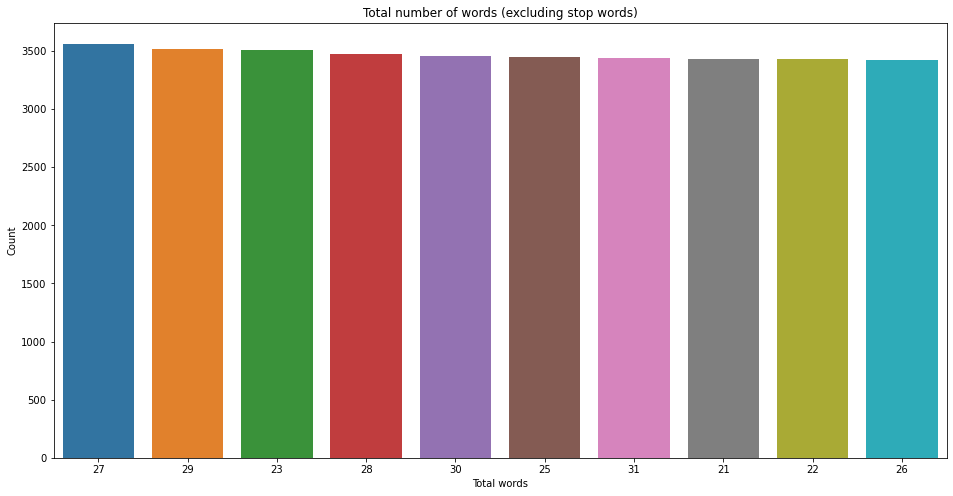

In [97]:
dataframe['total_words'] = dataframe['text_lemmatized'].apply(lambda x: len(x))
dataframe['unique_words'] = dataframe['text_lemmatized'].apply(lambda x: len(set(x)))

fig, ax = plt.subplots(figsize=(16,8))
ax = sns.countplot(
    data=dataframe,
    x='total_words',
    order = dataframe['total_words'].value_counts().iloc[:10].index
)
ax.set(ylabel="Count", xlabel="Total words", title="Total number of words (excluding stop words)")

Nous voyons que nous avons la plupart des commentaires contiennent entre 23 et 29 mots. Parmi eux, il peut y avoir le même mot qui apparaît plusieurs fois. Nous allons donc regarder le nombre de mot unique par commentaire.

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Unique words'),
 Text(0.5, 1.0, 'Unique number of words (excluding stop words)')]

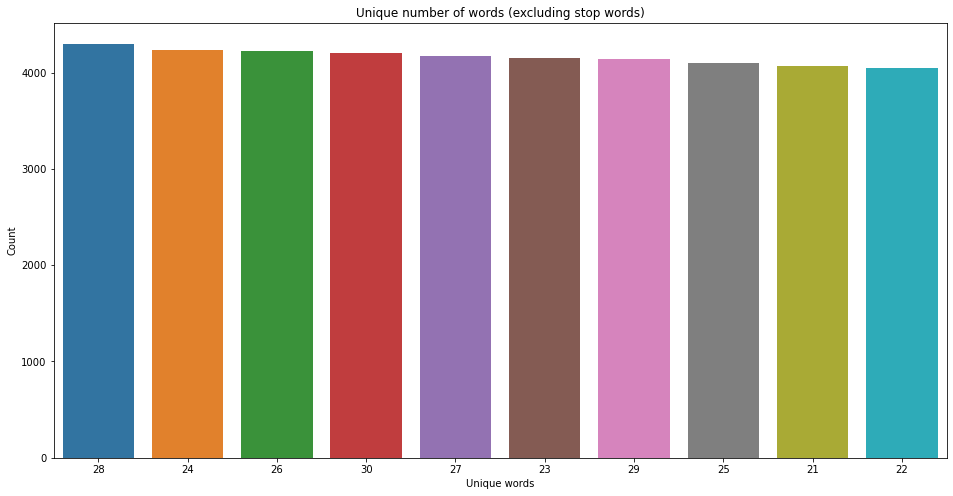

In [98]:
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.countplot(
    data=dataframe,
    x='unique_words',
    order = dataframe['unique_words'].value_counts().iloc[:10].index,
)
ax.set(ylabel="Count", xlabel="Unique words", title="Unique number of words (excluding stop words)")

Concernant le nombre de mots uniques, les commentaires en contiennent, pour la majorité, entre 24 et 30. Regardons maintenant quels sont les mots les plus utilisés.

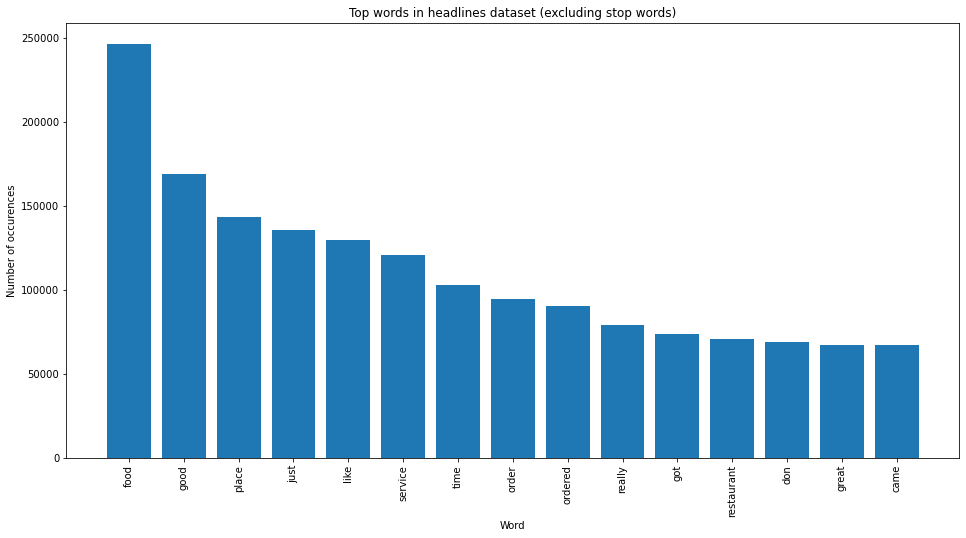

In [99]:
# Create function to get top words
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    vectorized_headlines = count_vectorizer.fit_transform(text_data)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15, count_vectorizer=count_vectorizer, text_data=dataframe['text'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

On remarque que les mots les plus utilisés sont "food", "place" et "good". Ce qui nous indique que les commentaires tournent autour du restaurant, de la localisation de ce dernier et du goût.

### 4. Modélisation des données textuelles<a class="anchor" id="II4"></a>

#### a. Latent Dirichlet Allocation (LDA)<a class="anchor" id="II4a"></a>

Nous allons modéliser les sujets d'insatisfaction présents dans les commentaires. Pour cela, nous allons utiliser une première méthode vraiment efficace nommée **Latent Dirichlet Allocation (LDA)**. Cette dernière va considérer chacun de nos commentaires comme un bag-of-words. Chaque commentaire va aborder un certain nombre de thèmes dans des proportions qui lui sont propres, chaque mot possède une distribution associée à chaque thème. Cela permet de représenter chaque thème par une probabilité sur chaque mot.

Nous allons commencer par former les bigrammes et les trigrammes en utilisant le modèle Phrases. Ceci est passé à Phraser pour améliorer l'efficacité de la vitesse d'exécution.

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(dataframe['text_lemmatized'], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[dataframe['text_lemmatized']], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Get stop words
stop_words = nltk.corpus.stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stop words once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(dataframe['text_lemmatized'])

Pour construire le modèle de sujet LDA, nous avons d'abord créé un corpus et un dictionnaire, puis nous avons construit le modèle.

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, update_every=1,
                                           chunksize=10, passes=10, alpha='symmetric', per_word_topics=True)

Dans les modèles LDA, chaque document est composé de plusieurs sujets. Mais, généralement, un seul des sujets est dominant. Le code ci-dessous extrait ce sujet dominant pour chaque phrase et montre le poids du sujet et des mots-clés dans une sortie bien formatée.

De cette façon, nous savons quel document appartient principalement à quel sujet.

In [16]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=dataframe.text.values.tolist()):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
dominant_topic = df_topic_sents_keywords.reset_index()
dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8385,"order, get, time, go, food, say, ask, take, wa...","[place, recently, almost, mentality, untouchab..."
1,1,3.0,0.5165,"good, food, get, place, go, order, chicken, pr...","[rude, slow, food, cold, really, go, take, min..."
2,2,1.0,0.6844,"order, get, time, go, food, say, ask, take, wa...","[easy, person, term, service, never, complain,..."
3,3,3.0,0.5472,"good, food, get, place, go, order, chicken, pr...","[go, expect, service, verrry, order, come, fir..."
4,4,1.0,0.6462,"order, get, time, go, food, say, ask, take, wa...","[use, nice, place, fall, think, forgot, purpos..."
5,5,3.0,0.6400,"good, food, get, place, go, order, chicken, pr...","[pretty, good, make, great, cupcake, bad, inst..."
6,6,0.0,0.4403,"table, food, drink, good, place, service, serv...","[kenny_zuke, deli, force, go, starve, downtown..."
7,7,3.0,0.6621,"good, food, get, place, go, order, chicken, pr...","[good, figured, return, mom, choice, order, bl..."
8,8,2.0,0.6011,"sauce, dish, taste, flavor, make, side, salad,...","[japanese, sushifusion, buffet, restaurant, ma..."
9,9,0.0,0.7685,"table, food, drink, good, place, service, serv...","[room, nice, service, tv, channel, analog, nic..."


Nous affichons ici la suite de mots les plus représentatifs du sujet dominant.

In [17]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9779,"table, food, drink, good, place, service, server, great, bar, restaurant","[go, night, reservation, still, wait, feel, know, want, restaurant, night, club, loud, really, p..."
1,1.0,0.9896,"order, get, time, go, food, say, ask, take, wait, come","[order, pizza, online, pm, call, store, restaurant, tell, get, order, place, phone, tell, delive..."
2,2.0,0.9717,"sauce, dish, taste, flavor, make, side, salad, bit, sandwich, little","[taste, bagel, decide, fan, bagel, taste, bread, instead, chewy, ny_style, bagel, use, also, try..."
3,3.0,0.9863,"good, food, get, place, go, order, chicken, pretty, fry, well","[slow, slow, slow, slow, slow, slow, slow, slow, service, slow, slow, slow, slow, slow, slow, sl..."


Nous voyons par exemple que le topic 0 semble traiter de l'attente des réservations la nuit pour les restaurants, tandis que le topic 1 lui pourrait traiter de la commande en ligne dans les restaurants notamment les pizzerias.

Bien que nous ayons déjà vu quels sont les mots-clés de chaque sujet, un nuage de mots dont la taille des mots est proportionnelle au poids nous donne une visualisation plus parlante.

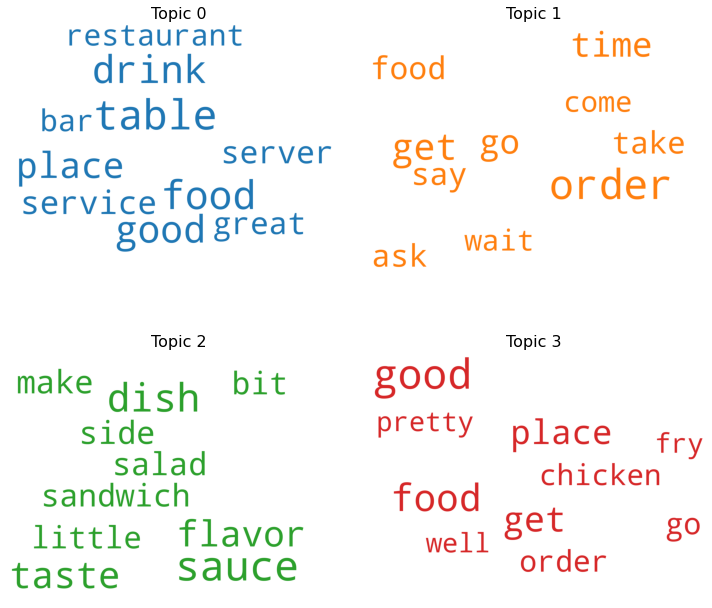

In [22]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Ce nuage de mots semble bien vérifier les observations que nous avons fait précédemment sur les thèmes traités dans les différents topics.

Nous allons calculer le nombre total de documents attribués à chaque sujet. Ensuite, nous ferons deux graphiques : 
* le nombre de documents pour chaque sujet en attribuant le document au sujet qui a le plus de poids dans ce document ;
* le nombre de documents pour chaque sujet en additionnant la contribution réelle en poids de chaque sujet aux documents respectifs.

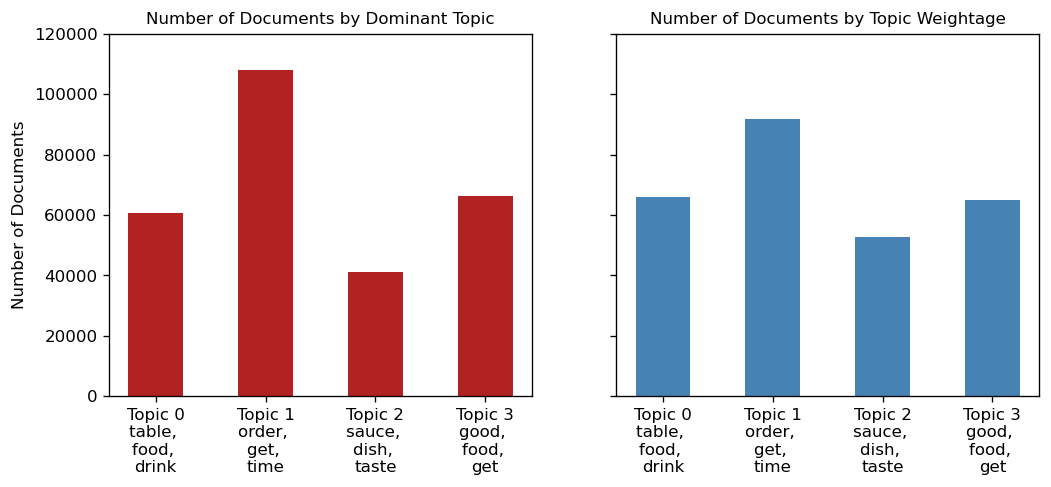

In [42]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 120000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

On remarque que les topics les plus importants à travers les différents documents sont, dans l'ordre : le 1, le 3, le 0 et en dernier le 2.

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

Chaque bulle sur le graphique de gauche représente un topic. Plus la bulle est grosse, plus ce sujet est présent. Un bon topic aura des bulles assez grosses et non superposées dispersées dans le graphique au lieu d'être regroupées dans un quadrant. Un topic avec trop de sujets aura généralement de nombreux chevauchement et des bulles de petite taille regroupées dans une région du graphique.

En déplaçant le curseur sur les bulles, les mots et les barres sur le côté droit sont mis à jour. Ces mots sont les mots clés formant le sujet sélectionné.

En nous basant sur ce que nous venons de voir, on peut déterminer que les topics 3 et 4 sont de bons topics. En effet, même si leurs bulles sont plus petites que celles des topics 1 et 2, elles n'en chevauchent aucunes autres. On voit en allant dessus que le topic 3 semble traiter de l'attente dans le restaurant et du service. Tandis que le topic 4, lui, traite de la nourriture servie dans le restaurant.

#### b. Latent Semantic Analysis (LSA)<a class="anchor" id="II4b"></a>

Voyons maintenant la **Latent Semantic Analysis (LSA)**. La LSA permet de découvrir la sémantique cachée et sous-jacente (latente) de mots dans un corpus de documents en construisant des "concepts" liés aux documents et aux termes. La LSA utilise une matrice documents-termes en entrée qui décrit l'occurrence de certains termes dans les documents. C'est une matrice creuse dont les lignes correspondent aux "documents" et dont les colonnes correspondent aux "termes".

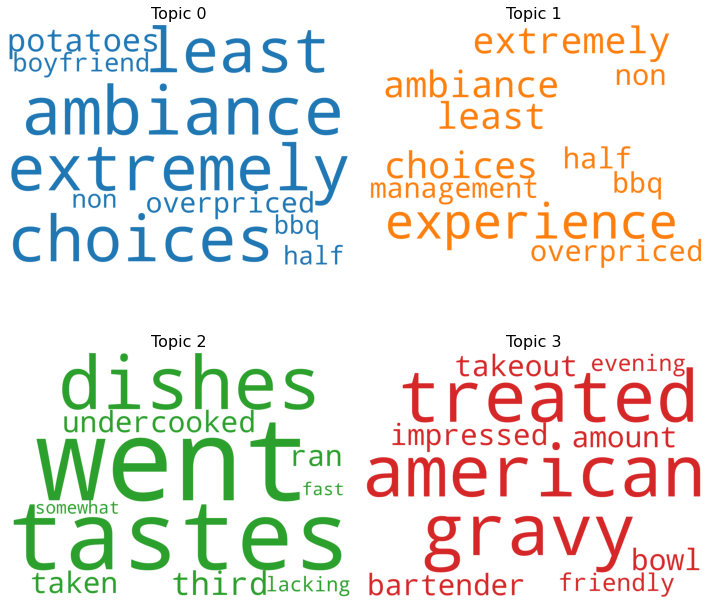

In [158]:
lsa_model = TruncatedSVD(n_components=4)

count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
document_term_matrix = count_vectorizer.fit_transform(dataframe['text'].values)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)
# Most important words for each topic
vocab = count_vectorizer.get_feature_names()

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800, 
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    imp_words_topic = ""
    comp = lsa_model.components_[i]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x: x[1], reverse=True)[:50]
    for word in sorted_words:
        imp_words_topic = imp_words_topic + " " + word[0]
    cloud.generate(imp_words_topic)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

On voit que le topic 0 semble traiter du prix trop élevé et du choix des menus, tandis que le topic 2 lui pourrait traiter du goût, de la vaisselle et de la cuisson des plats. Enfin le topic 1 luiu doit parler de l'ambiance dans le restaurant, de l'expérience et du management.

#### c. Non-Negative Matrix Factorisation (NMF)<a class="anchor" id="II4c"></a>

Pour finir, la **Non-Negative Matrix Factorisation (NMF)**. Celle-ci est une technique non supervisée, il n'y a donc pas d'étiquetage des sujets sur lesquels le modèle sera formé. La façon dont cela fonctionne est que NMF décompose (ou factorise) les vecteurs de grande dimension en une représentation de dimension inférieure. Ces vecteurs de dimension inférieure sont non négatifs, ce qui signifie également que leurs coefficients sont non négatifs. 

En utilisant la matrice d'origine (A), **NMF** vous donnera deux matrices (W et H). W est les sujets qu'il a trouvés et H est les coefficients (poids) pour ces sujets. En d'autres termes, A correspond aux articles par mots (original), H correspond aux articles par thèmes et W aux thèmes par mots.

C:\Users\raoof\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


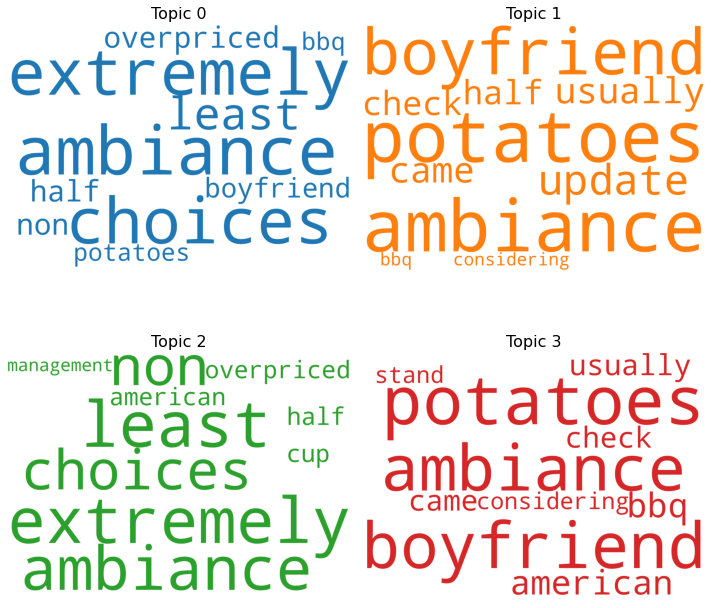

In [161]:
nmf_model = NMF(n_components=4, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')

count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
document_term_matrix = count_vectorizer.fit_transform(dataframe['text'].values)
nmf_topic_matrix = nmf_model.fit_transform(document_term_matrix)

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800, 
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    imp_words_topic = ""
    comp = nmf_model.components_[i]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x: x[1], reverse=True)[:50]
    for word in sorted_words:
        imp_words_topic = imp_words_topic + " " + word[0]
    cloud.generate(imp_words_topic)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

On remarque que le topic 0 parle de l'ambiance, du prix des plats ainsi que des choix. Les autres topics sont moins clairs, il est plus difficile de les décrypter. 

## III. Pré-traitement et modélisation des données visuelles<a class="anchor" id="III"></a>

### 1. Chargement des données visuelles<a class="anchor" id="III1"></a>

Nous allons maintenant importer nos données visuelles dans un dataframe et les labels associés à ces derniers par la même occasion. 

In [25]:
# Get picture data
picture_json_path = 'data/photos.json'
dataframe_picture = pd.read_json(picture_json_path, lines=True)

# Drop caption column
dataframe_picture = dataframe_picture.drop(['caption'], axis=1)

# Rename column
dataframe_picture = dataframe_picture.rename(columns={'photo_id': 'path'})

# Format path
dataframe_picture['path'] = dataframe_picture['path'].apply(lambda x: x + '.jpg')

# Rename label column
dataframe_picture = dataframe_picture.rename(columns={'label': 'label_name'})

# Export dataframe to csv
dataframe_picture.to_csv('data/dataframe_picture.csv', index=False)

# Encoding labels
le = LabelEncoder()
dataframe_picture["label"] = le.fit_transform(dataframe_picture["label_name"])

# Get list of photos
path = "C:/Users/raoof/Downloads/photos/"
list_photos = [file for file in listdir(path)]

# Dataframe columns info
dataframe_picture.info()

# Dataframe features
dataframe_picture.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   path         200000 non-null  object
 1   business_id  200000 non-null  object
 2   label_name   200000 non-null  object
 3   label        200000 non-null  int32 
dtypes: int32(1), object(3)
memory usage: 5.3+ MB


,path,business_id,label_name,label
0,Un_Og6jfhazVn7CxszkKEw.jpg,R1sIqGfKpF5f3HV3vyNsbg,drink,0
1,BFE1AFOs27scnnfeBf99ZA.jpg,vdT7zlrLB2DL9pStDUs91A,drink,0
2,7t-C0r1JRdoVD9FS7M-N7Q.jpg,c5GzrObEdj7eNVOdAxrppg,drink,0
3,rLnw0d-YYZvT9kR4y7h7_Q.jpg,aQa7N5ZbPhCoKYGGB-gqfg,drink,0
4,Cv5M8MDw8a5NEWvw2AQ4nw.jpg,B-s6qOFD75syhwWjp518aA,drink,0


Nos données contiennent 4 variables pour 200 000 individus. Nous avons supprimé les colonnes inutiles et formaté la chemin pour accéder aux images.

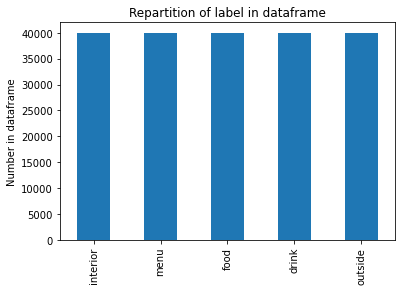

In [3]:
# Plot the labels in the dataframe
dataframe_picture["label_name"].value_counts().plot.bar()

# Plot labeling
plt.ylabel('Number in dataframe')
plt.title('Repartition of label in dataframe');

Notre jeu de données contient 5 labels différents équirépartis.

menu


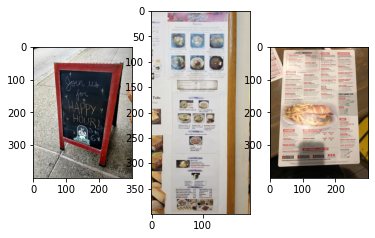

outside


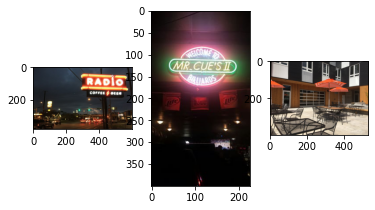

food


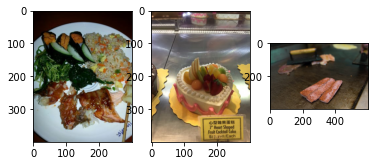

drink


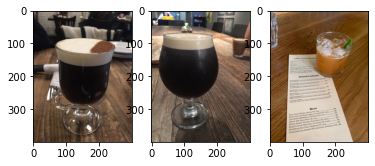

interior


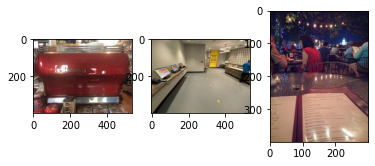

In [4]:
# Create list of label available
list_labels = ["menu", "outside", "food", "drink", "interior"]

def list_fct(name) :
    list_image_name = [dataframe_picture['path'][i] for i in range(len(dataframe_picture)) if 
                       dataframe_picture["label_name"][i] == name]
    return list_image_name

# Create list for each label
list_menu = [dataframe_picture['path'][i] for i in range(len(dataframe_picture)) if 
             dataframe_picture["label_name"][i] == "menu"]
list_outside = [dataframe_picture['path'][i] for i in range(len(dataframe_picture)) if 
                dataframe_picture["label_name"][i] == "outside"]
list_food = [dataframe_picture['path'][i] for i in range(len(dataframe_picture)) if 
             dataframe_picture["label_name"][i] == "food"]
list_drink = [dataframe_picture['path'][i] for i in range(len(dataframe_picture)) if 
              dataframe_picture["label_name"][i] == "drink"]
list_interior = [dataframe_picture['path'][i] for i in range(len(dataframe_picture)) if 
                 dataframe_picture["label_name"][i] == "interior"]

# Display picture for differents labels
for name in list_labels:
    print(name)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + '/' + list_fct(name)[i + 10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

Nous avons affiché ici des exemples de photos pour chacuns des labels disponibles.

### 2. Pré-traitement des images via SIFT<a class="anchor" id="III2"></a>

Nous allons procéder à la création des descripteurs de chaque image. Chaque image va passer en gris et va subir une égalisation. Ensuite, nous allons créer une liste de descripteurs par image qui sera utilisée pour réaliser les histogrammes par image. Enfin, nous créerons une liste de descripteurs pour l'ensemble des images qui sera utilisé pour créer les clusters de descripteurs.

In [26]:
# identification of key points and associated descriptors
sift_keypoints = []
temps1 = time.time()
sift = cv2.xfeatures2d.SIFT_create(50)
from os import path as pp
for image_num in range(len(list_photos)) :
    image = cv2.imread(path + list_photos[image_num], 0) # convert in gray
    res = cv2.equalizeHist(image) # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print("Number of descriptors : ", sift_keypoints_all.shape)

duration1 = time.time() - temps1
print("Processing time SIFT descriptor : ", "%15.2f" % duration1, "seconds")

C:\Users\raoof\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Number of descriptors :  (10056018, 128)
Processing time SIFT descriptor :         33421.87 seconds


On a donc créé nos descripteurs. Nous allons maintenant créer des clusters de descripteurs à l'aide de MiniBatchKMeans pour obtenir des temps de traitement raisonnables.

In [27]:
# Determination number of clusters
temps1 = time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Number of estimated clusters : ", k)
print("Creation of", k, "clusters of descriptors...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("Processing time kmeans : ", "%15.2f" % duration1, "seconds")

Number of estimated clusters :  3171
Creation of 3171 clusters of descriptors...


C:\Users\raoof\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


Processing time kmeans :          2049.51 seconds


Nous avons créé 3 171 clusters en environ 1 heure. On peut passer à la création de features pour les images. Pour chaque image, nous allons prédire les numéros de cluster de chaque descripteur. Ensuite nous allons créer un histogramme, c'est-à-dire le comptage pour chaque numéro de cluster du nombre de descripteurs de l'image.
Pour rappel, les features d'une image sont l'histogramme d'une image, soit le comptage pour une image du nombre de descripteurs par cluster.

In [28]:
# Creation of histograms (features)
temps1 = time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    hist = build_histogram(kmeans, image_desc, i) # calculates the histogram
    hist_vectors.append(hist) # histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("Processing time histograms : ", "%15.2f" % duration1, "seconds")

Processing time histograms :          1546.75 seconds


Nos histogrammes ont été créé en 26 minutes. Nous allons passer à la réduction de dimensions.

### 3. Réductions de dimension<a class="anchor" id="III3"></a>

#### a. Réduction de dimension PCA<a class="anchor" id="III3a"></a>

La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%). L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE.

In [29]:
print("Dimensions dataset befor PCA reduction : ", im_features.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset after PCA reduction : ", feat_pca.shape)

Dimensions dataset befor PCA reduction :  (199999, 3171)
Dimensions dataset after PCA reduction :  (199999, 2177)


Nous sommes de 3171 dimensions avant la réduction de dimensions PCA à 2177 dimensions.

#### b. Réduction de dimension T-SNE<a class="anchor" id="III3b"></a>

Nous effectuons maintenant une réduction de dimension en 2 composantes T-SNE pour un affichage en 2D des images.

In [30]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = dataframe_picture["label_name"]
print(df_tsne.shape)

(199999, 3)


Passons à l'analyse visuelle avec un affichage T-SNE.

### 4. Analyse visuelle : affichage T-SNE selon les catégories d'images<a class="anchor" id="III4"></a>

Nous allons donc commencer par afficher nos deux composantes T-SNE.

C:\Users\raoof\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


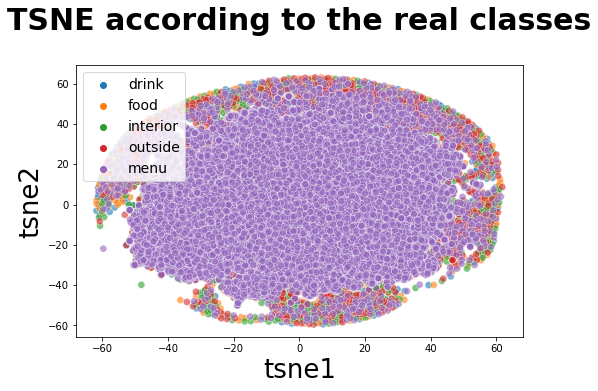

In [31]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE according to the real classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize=26)
plt.ylabel('tsne2', fontsize=26)
plt.legend(prop={'size': 14}) 

plt.show()

Nos catégories ne sont absolument pas séparées.

### 5. Analyse mesures : similarité entre catégories et clusters<a class="anchor" id="III5"></a>

#### a. Création de clusters à partir du T-SNE<a class="anchor" id="III5a"></a>

In [74]:
cls = cluster.KMeans(n_clusters=5, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(199999, 4)


Comme indiqué, nous avons créé nos clusters à partir du T-SNE effectué précédemment.

#### b. Affichage des images selon clusters et calcul ARI de similarité catégories images/clusters<a class="anchor" id="III5b"></a>

C:\Users\raoof\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


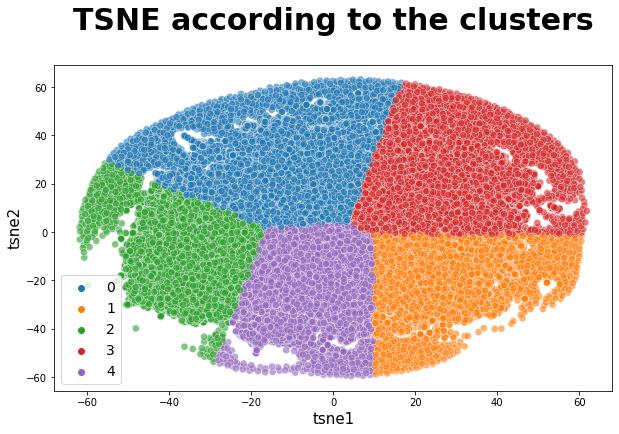

ARI :  0.0008103490833824236


C:\Users\raoof\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\Users\raoof\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))


In [76]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE according to the clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize=15)
plt.ylabel('tsne2', fontsize=15)
plt.legend(prop={'size': 14}) 

plt.show()

labels = dataframe_picture["label"][:199999]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Le score ARI, de 0.0008, reste extrêmement faible.